In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append("../")

from src.detection.prediction_utils import get_model, filter_predictions, visualize_boxes
from src.slides_utils.slides_utils import predict_tiles
from src.line_detection.hough import get_pairs
from src.ocr_utils.ocr import get_ocr_model, predict_ocr, generate_db

2023-03-12 21:33:36.306051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 21:33:38.898002: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-12 21:33:38.899151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packag

In [3]:
from PIL import Image
from torchvision import transforms as T
import torch
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
transform = T.Compose([T.ToTensor()])

model_tablas = get_model(object_to_predict="tablas")
model_cardinalidades = get_model(object_to_predict="cardinalidades")

Using cache found in /home/nacho/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-8 Python-3.8.10 torch-1.13.0+cu117 CPU

Fusing layers... 
Model summary: 261 layers, 61513585 parameters, 0 gradients, 154.6 GFLOPs
Adding AutoShape... 


In [5]:
def reescale(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    return img

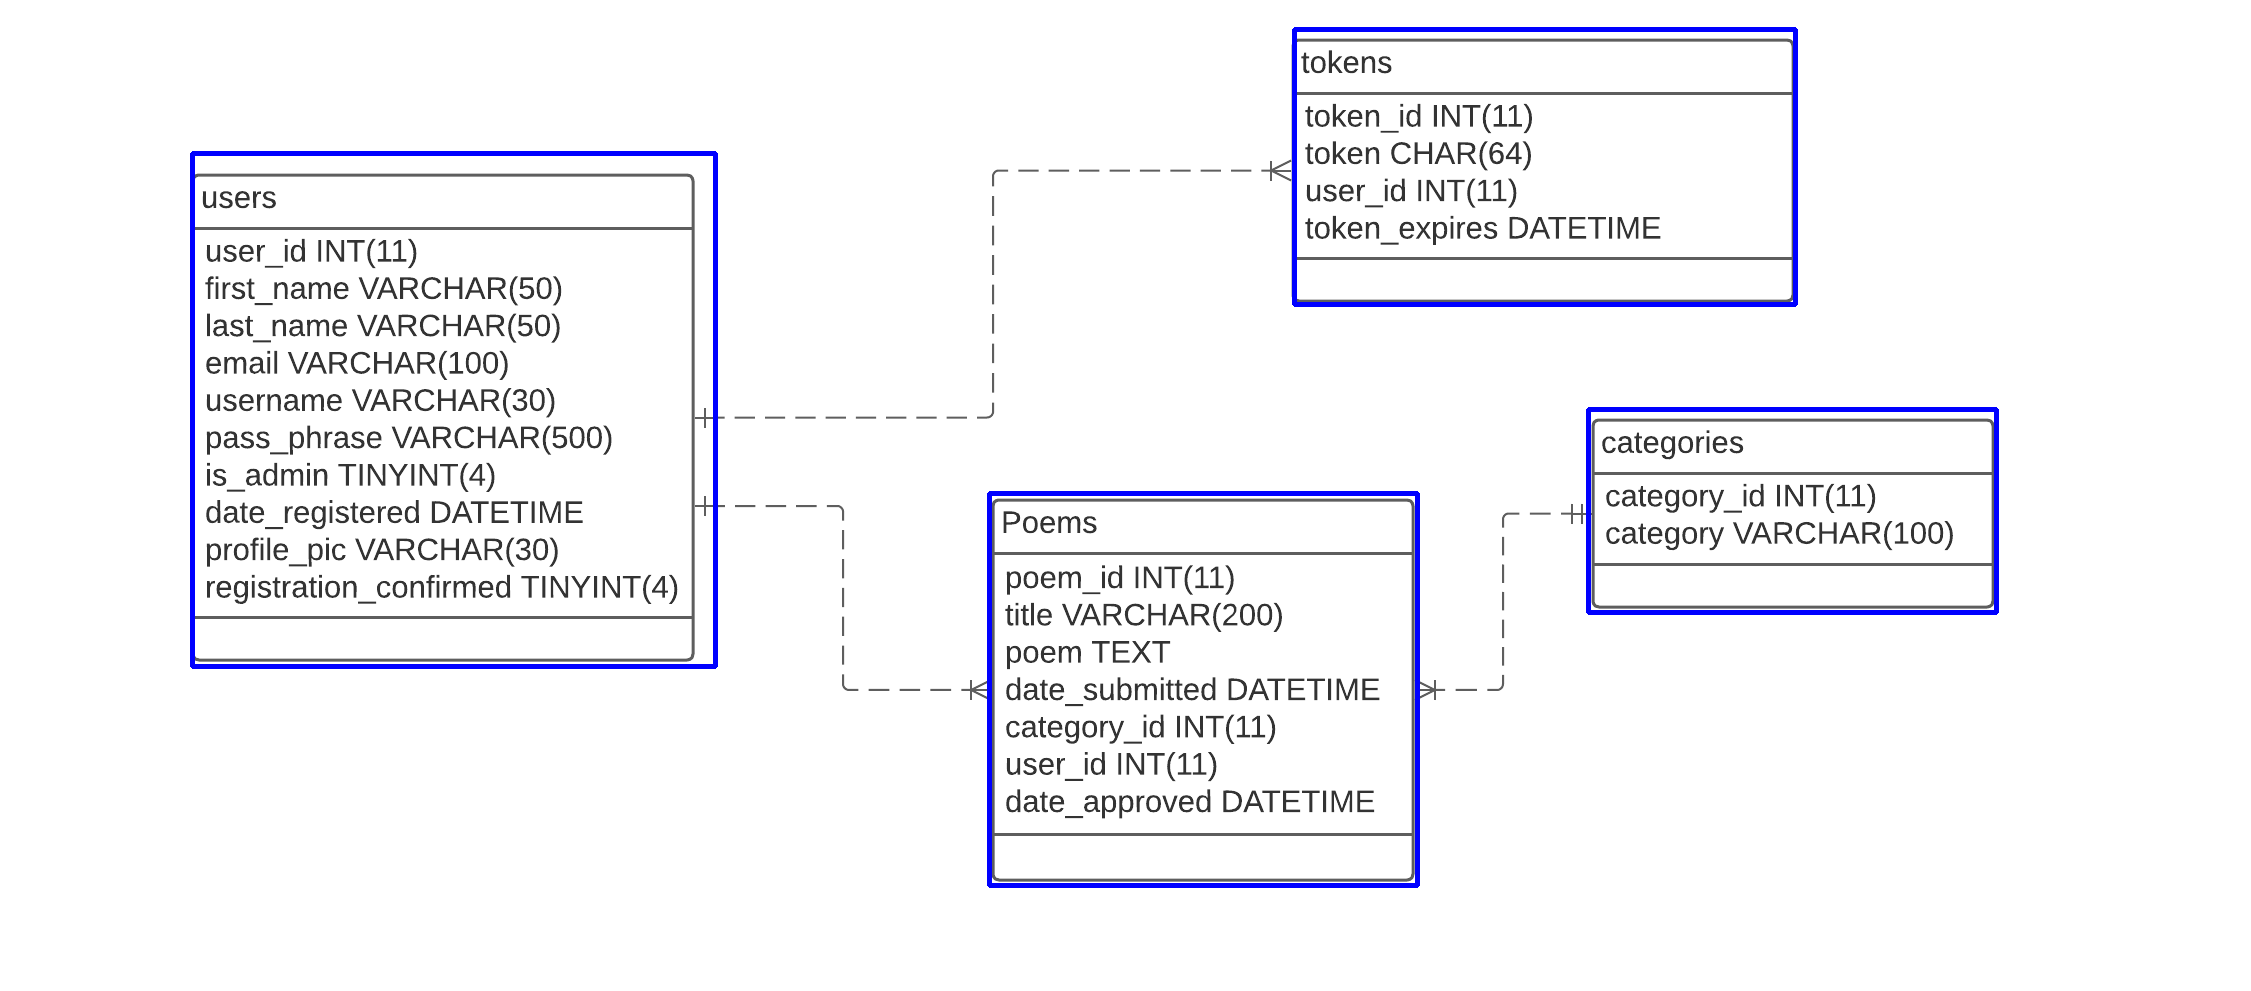

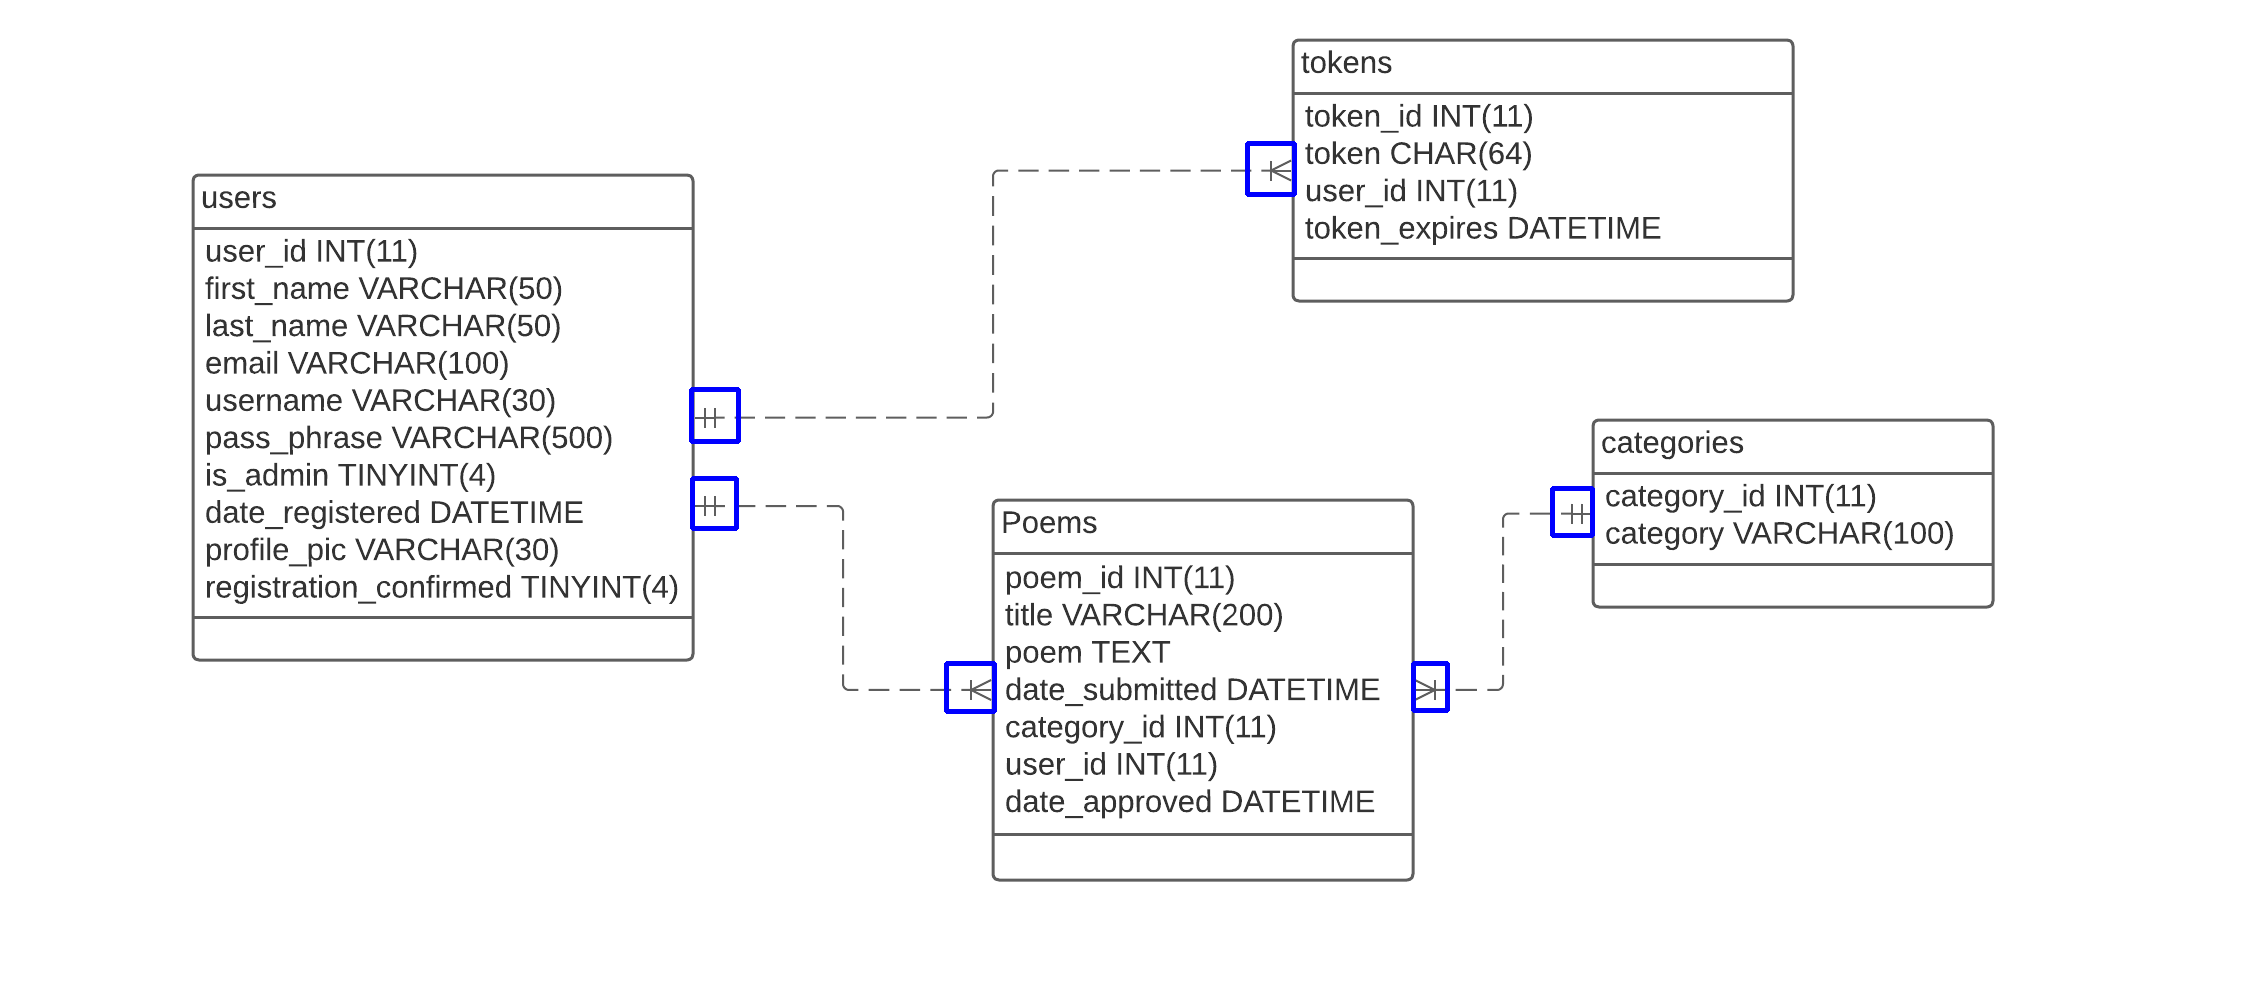

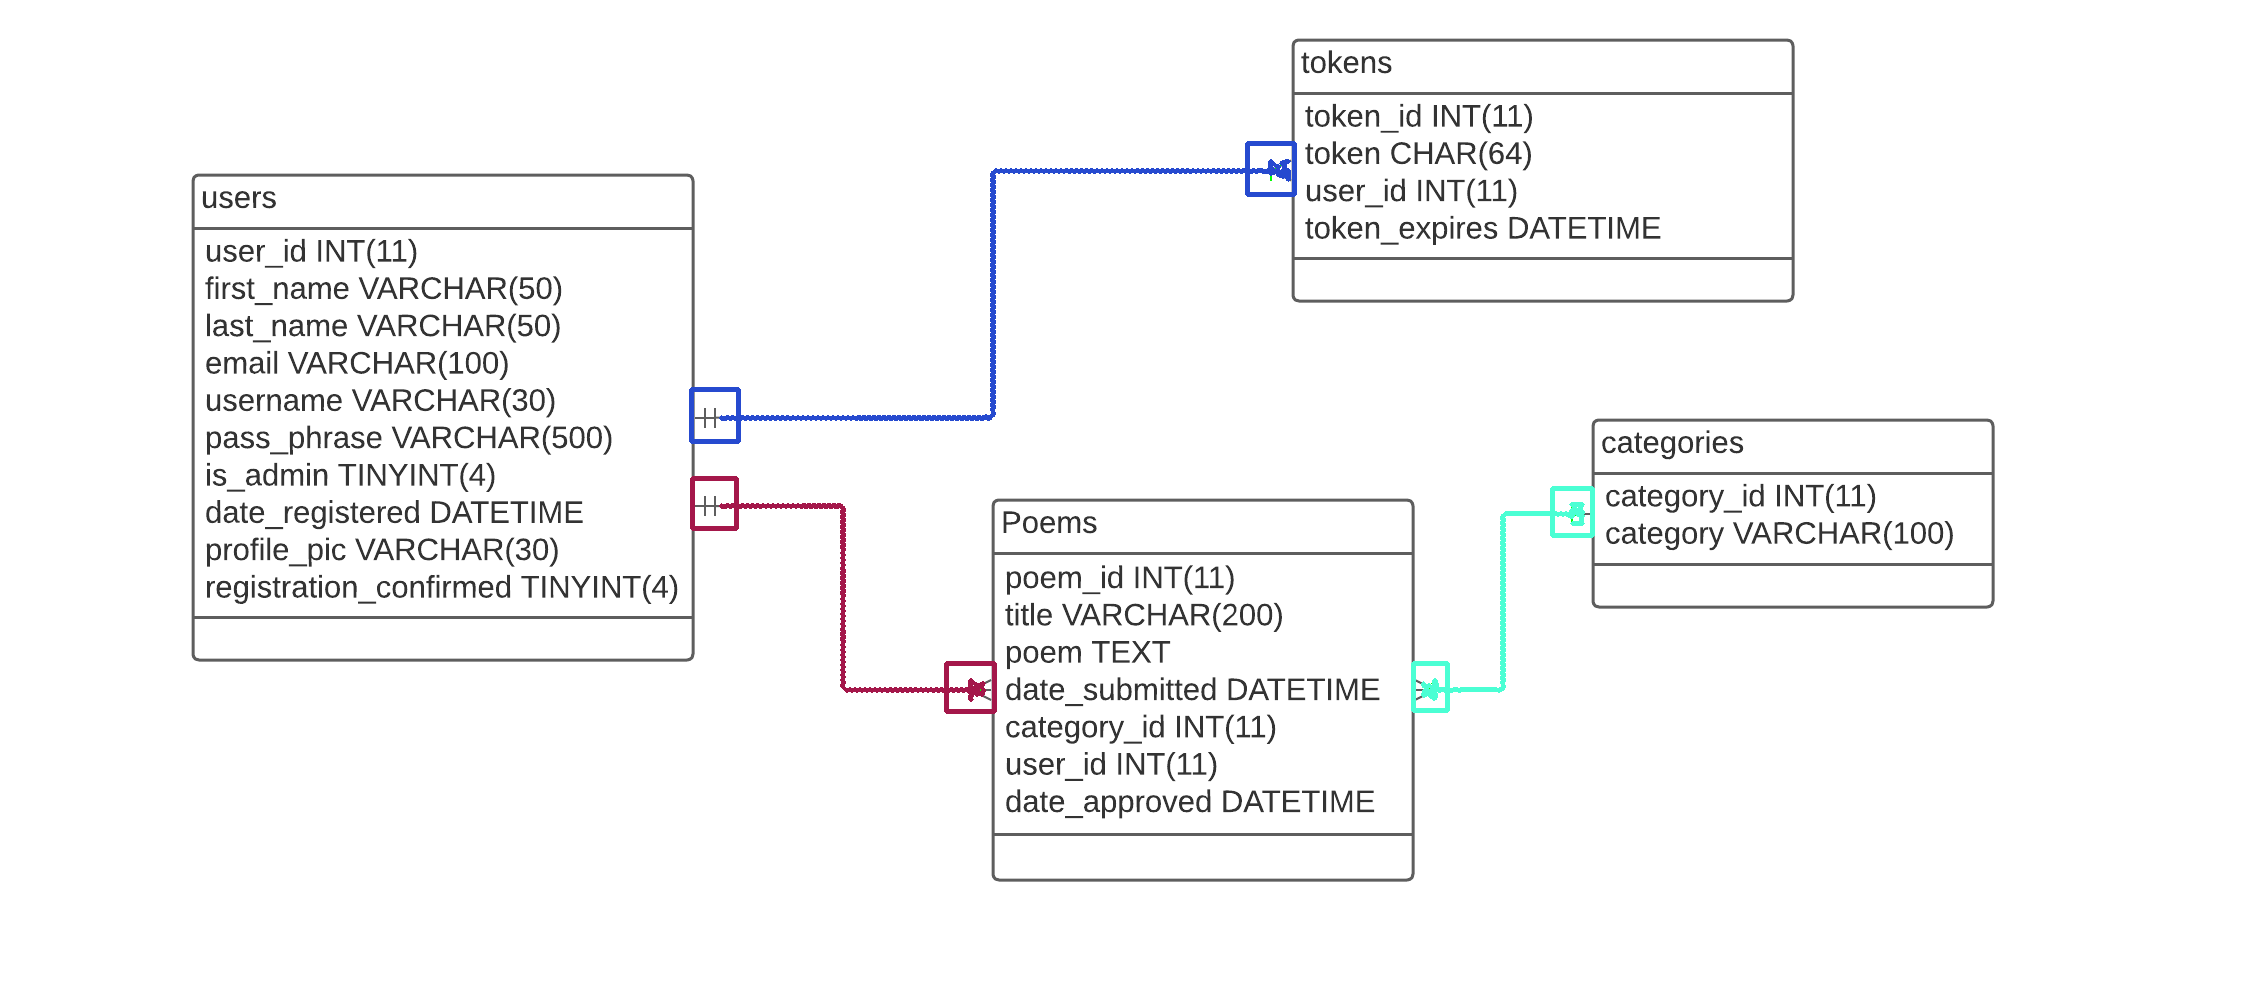

In [7]:
img_path = "/home/nacho/TFI-Cazcarra/data/images_testing/demostracion_lucid.png"
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img)

tablas_pred = model_tablas([img_tensor])[1][0]
tablas_boxes, tablas_scores = filter_predictions(tablas_pred, nms_threshold=0.5, score_threshold=0.5)
cardinalidades_pred = predict_tiles(img, model=model_cardinalidades, is_yolo=True, transform=transform)
cardinalidades_boxes, cardinalidades_scores = filter_predictions(cardinalidades_pred, nms_threshold=0.5, 
                                                             score_threshold=0.5)

display(visualize_boxes(img, tablas_boxes, color=(0,0,255), thickness=3))
display(visualize_boxes(img, cardinalidades_boxes, color=(0,0,255), thickness=3))

conexiones = get_pairs(tablas_boxes, cardinalidades_boxes, img=img, plot=True)

In [8]:
ocr = get_ocr_model()

In [9]:
def draw_bbox_ocr(img, xmin, ymin, xmax, ymax, color):
    isClosed = True
    thickness = 2
    pts = np.array([xmin, ymin, xmax, ymax])
    return cv2.polylines(img, [pts], isClosed, color, thickness)

def visualize_boxes_ocr(img, boxes, color=(0, 255, 0)):
    img = np.array(img)
    for b in boxes:
        xmin = b[0].astype(int).tolist()
        ymin = b[1].astype(int).tolist()
        xmax = b[2].astype(int).tolist()
        ymax = b[3].astype(int).tolist()
        img = draw_bbox_ocr(img, xmin, ymin, xmax, ymax, color)
    return Image.fromarray(img)

def images_together(images, titles=[]):
    rcParams["figure.figsize"] = (10,6)
    
    fig, ax = plt.subplots(1,len(images))
    for i in range(len(images)):
        ax[i].imshow(images[i])
        if titles:
            ax[i].set_title(titles[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

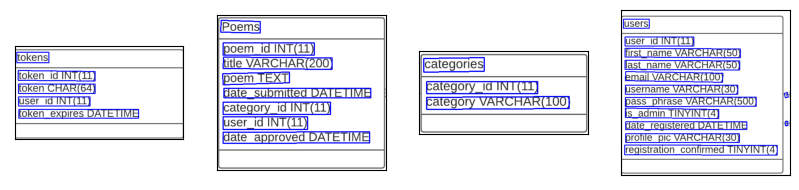

None

In [10]:
img_arr = np.array(img)
plots = []


for t in tablas_boxes:
    t = t.detach().numpy().astype(int).tolist()
    tabla_cropped = img_arr[t[1]:t[3], t[0]:t[2]]
    if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
        tabla_cropped = tabla_cropped[:,:,:3]
    boxes_default, _ = ocr.text_detector(tabla_cropped)
    plotted = visualize_boxes_ocr(tabla_cropped, boxes_default, color=(0, 0, 255))
    plots.append(plotted)

%matplotlib inline
display(images_together(plots,titles=[]))

In [11]:
tablas_boxes = tablas_boxes.detach().numpy().astype(int)
all_tables, tables_names = predict_ocr(img=img, tablas=tablas_boxes, ocr_model=ocr, scale_percent=100)

In [14]:
from pprint import pprint

pprint(all_tables)

{'categories': {'category': 'VARCHAR(100)', 'category_id': 'INT(11)'},
 'poems': {'category_id': 'INT(11)',
           'date_approved': 'DATETIME',
           'date_submitted': 'DATETIME',
           'poem': 'TEXT',
           'poem_id': 'INT(11)',
           'title': 'VARCHAR(200)',
           'user_id': 'INT(11)'},
 'tokens': {'token': 'CHAR(64)',
            'token_expires': 'DATETIME',
            'token_id': 'INT(11)',
            'user_id': 'INT(11)'},
 'users': {'date_registered': 'DATETIME',
           'email': 'VARCHAR(100)',
           'first_name': 'VARCHAR(50)',
           'is_admin': 'TINYINT(4)',
           'last_name': 'VARCHAR(50)',
           'pass_phrase': 'VARCHAR(500)',
           'profile_pic': 'VARCHAR(30)',
           'registration_confirmed': 'TINYINT(4)',
           'user_id': 'INT(11)',
           'username': 'VARCHAR(30)'}}


In [15]:
code = generate_db(conexiones, all_tables, tables_names, lang="en")
print(code)

 CREATE TABLE tokens ( 
   token_id INT(11),
   token CHAR(64),
   user_id INT(11),
   token_expires DATETIME,
   PRIMARY KEY (token_id) 
 ); 
 CREATE TABLE poems ( 
   poem_id INT(11),
   title VARCHAR(200),
   poem TEXT,
   date_submitted DATETIME,
   category_id INT(11),
   user_id INT(11),
   date_approved DATETIME,
   PRIMARY KEY (poem_id) 
 ); 
 CREATE TABLE categories ( 
   category_id INT(11),
   category VARCHAR(100),
   PRIMARY KEY (category_id) 
 ); 
 CREATE TABLE users ( 
   user_id INT(11),
   first_name VARCHAR(50),
   last_name VARCHAR(50),
   email VARCHAR(100),
   username VARCHAR(30),
   pass_phrase VARCHAR(500),
   is_admin TINYINT(4),
   date_registered DATETIME,
   profile_pic VARCHAR(30),
   registration_confirmed TINYINT(4),
   PRIMARY KEY (user_id) 
 ); 

ALTER TABLE tokens ADD FOREIGN KEY (user_id) REFERENCES users(user_id); 
ALTER TABLE poems ADD FOREIGN KEY (user_id) REFERENCES users(user_id); 
ALTER TABLE poems ADD FOREIGN KEY (category_id) REFERENCES catego